## 基于Backtrader的量化回测教程

### 使用Akshare作为数据源，对股票做策略回测

backtrader是一个开源的Python框架，用于开发、测试和部署基于时间序列数据的交易策略。
它提供了一系列工具和API，用于快速构建和优化交易策略，并支持多种市场数据源。
backtrader的主要特点包括：

- 高度可定制化：backtrader提供了广泛的配置选项和自定义指标，使得用户可以根据自己的需求快速构建自己的交易策略。

- 多种市场数据源：backtrader支持多种市场数据源，包括CSV、Pandas、Yahoo Finance、Alpha Vantage等，用户可以根据自己的需求选择适合自己的数据源。

- 回测和优化工具：backtrader提供了回测和优化工具，用户可以通过回测和优化工具，测试和优化自己的交易策略。

- 多种交易模式：backtrader支持多种交易模式，包括回归测试、实时模拟和交易回测等，用户可以选择适合自己的交易模式。

- 支持多种交易品种：backtrader支持多种交易品种，包括股票、期货、外汇等，用户可以根据自己的需求选择适合自己的交易品种。

### 1. 安装依赖

In [1]:
# !pip install tushare==1.2.85
# !pip install akshare -U
# !pip install backtrader==1.9.76.123
# !pip install pandas==1.5.2 --user

In [2]:
# pip install quantstats --user

### 2.导入相关的Python库

In [3]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib notebook

3.设置回测参数

In [4]:
start_date = '20150101'
end_date = '20230101'
symbol = '000001' #平安银行

##### **回测必知：股票数据复权**

1. **为何要复权**：由于股票存在**配股、分拆、合并**和发放股息等事件，会导致股价出现较大的缺口。 若使用不复权的价格处理数据、计算各种指标，将会导致它们**失去连续性**，且使用不复权价格计算收益也会出现错误。 为了保证数据连贯性，常通过前复权和后复权对价格序列进行调整。

2. **前复权**：保持当前价格不变，将历史价格进行增减，从而使股价连续。 前复权用来看盘非常方便，能一眼看出股价的历史走势，叠加各种技术指标也比较顺畅，是各种行情软件默认的复权方式。 这种方法虽然很常见，但也有两个缺陷需要注意。

     为了保证当前价格不变，每次股票除权除息，均需要重新调整历史价格，因此其历史价格是时变的。 这会导致在不同时点看到的历史前复权价可能出现差异。

     对于有持续分红的公司来说，前复权价可能出现负值。

3. **后复权**：保证历史价格不变，在每次股票权益事件发生后，调整当前的股票价格。 后复权价格和真实股票价格可能差别较大，不适合用来看盘。 其优点在于，可以被看作投资者的长期财富增长曲线，反映投资者的真实收益率情况。

4. **在量化投资研究中普遍采用后复权数据。**

In [6]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
print(stock_zh_a_hist_df)

              日期       开盘       收盘       最高       最低      成交量           成交额  \
0     2015-01-05  1797.18  1800.57  1829.92  1753.17  2860436  4.565388e+09   
1     2015-01-06  1781.38  1773.48  1842.33  1747.52  2166421  3.453446e+09   
2     2015-01-07  1748.65  1739.62  1779.13  1719.31  1700121  2.634796e+09   
3     2015-01-08  1741.88  1680.93  1749.78  1674.16  1407714  2.128003e+09   
4     2015-01-09  1674.16  1694.48  1783.64  1652.72  2508500  3.835378e+09   
...          ...      ...      ...      ...      ...      ...           ...   
1942  2022-12-26  2317.14  2281.38  2325.26  2271.63   797120  1.021904e+09   
1943  2022-12-27  2297.63  2336.64  2354.52  2297.63   886004  1.160090e+09   
1944  2022-12-28  2344.77  2341.52  2380.52  2318.76   791192  1.042402e+09   
1945  2022-12-29  2330.14  2323.64  2339.89  2294.38   666890  8.651450e+08   
1946  2022-12-30  2325.26  2344.77  2364.27  2312.26   818036  1.074757e+09   

        振幅   涨跌幅    涨跌额   换手率  
0     4.31  1.14  2

### 注意： Backtrader的日期列必须是升序排列

In [7]:
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume'},inplace=True)
stock_zh_a_hist_df = stock_zh_a_hist_df[['date','open','high','low','close','volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
#stock_zh_a_hist_df.sort_values(by='date', inplace=True)
stock_zh_a_hist_df

,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500
...,...,...,...,...,...,...
1942,2022-12-26,2317.14,2325.26,2271.63,2281.38,797120
1943,2022-12-27,2297.63,2354.52,2297.63,2336.64,886004
1944,2022-12-28,2344.77,2380.52,2318.76,2341.52,791192
1945,2022-12-29,2330.14,2339.89,2294.38,2323.64,666890


In [8]:
stock_zh_a_hist_df.close.max()

4233.66

### 4.编写策略类

In [17]:
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5) # 移动平均期数，5日均线
    
    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.period) #self.p.period
        
    def next(self):
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100) # 股数
        if not self.position.size: # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，全仓买入YY
            if self.datas[0].close[-1] < self.move_average.sma[-1] and self.datas[0].close[0] > self.move_average.sma[0]:
                self.buy(size=size)
        # 有仓位， 并且当日收盘价下破5日均线，创建卖单，全仓卖出
        elif self.datas[0].close[-1] > self.move_average.sma[-1] and self.datas[0].close[0] < self.move_average.sma[0]:
            self.close()

### 5.开始回测

In [18]:
#创建回测引擎对象
cerebro = bt.Cerebro()

In [22]:
stock_data = PandasData(
                dataname=stock_zh_a_hist_df,
                datetime=0, # 日期列
                open=1, # 开盘价所在列
                high=2, # 最高价所在列
                low=3, # 最低价所在列
                close=4, #收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'), # 起始日 dt.striptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'), # 结束日
            )
    

In [23]:
cerebro.adddata(stock_data, name='stock')

In [24]:
start_cash=1000000

In [25]:
cerebro.addstrategy(SmaCross)

0

In [26]:
cerebro.broker.setcash(start_cash)

In [27]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

In [28]:
print('初始市值： %.2f' % cerebro.broker.getvalue())

初始市值： 1000000.00


In [29]:
results = cerebro.run()
strat = results[0]

In [30]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

In [31]:
returns.index=returns.index.tz_convert(None)
print('最终市值： %.2f' % cerebro.broker.getvalue())

最终市值： 1739123.00


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             58.0%

Cumulative Return          73.91%
CAGR﹪                     4.9%

Sharpe                     0.45
Prob. Sharpe Ratio         89.52%
Smart Sharpe               0.43
Sortino                    0.71
Smart Sortino              0.69
Sortino/√2                 0.5
Smart Sortino/√2           0.49
Omega                      1.12

Max Drawdown               -35.46%
Longest DD Days            816
Volatility (ann.)          20.95%
Calmar                     0.14
Skew                       0.96
Kurtosis                   10.24

Expected Daily %           0.03%
Expected Monthly %         0.58%
Expected Yearly %          7.16%
Kelly Criterion            4.94%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.13%
Expected Shortfall (cVaR)  -2.13%

Max Consecutive Wins       9


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-02,2022-11-04,2022-12-30,697,-35.458351,-35.044880
2,2015-04-17,2016-02-25,2017-07-10,816,-21.039835,-19.699547
3,2017-11-23,2018-08-14,2019-02-28,463,-20.067205,-19.904511
4,2019-10-15,2020-04-03,2020-07-03,263,-14.301582,-13.394560
5,2015-01-16,2015-03-10,2015-04-07,82,-13.600000,-13.261500


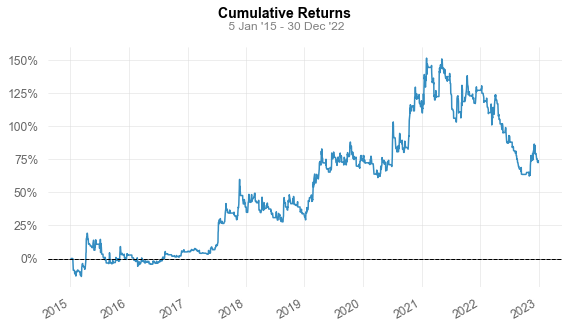

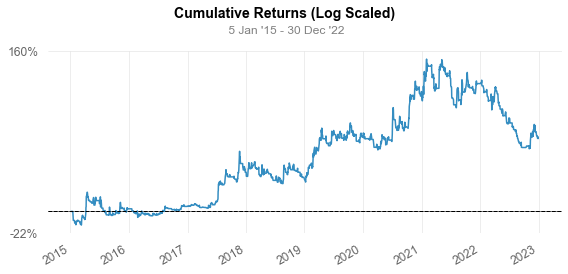

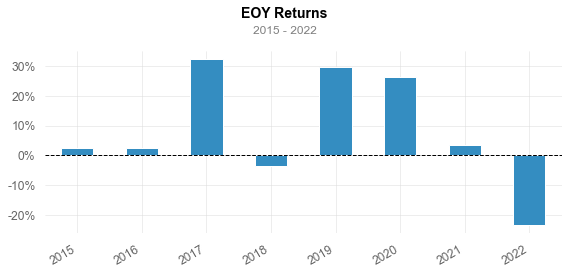

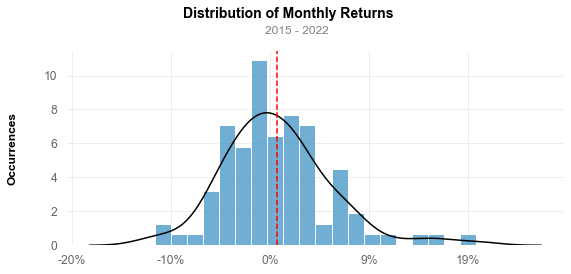

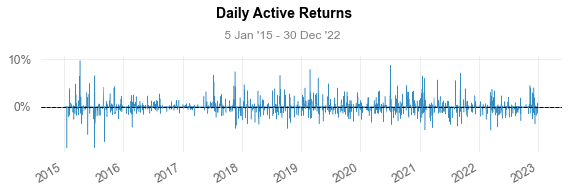

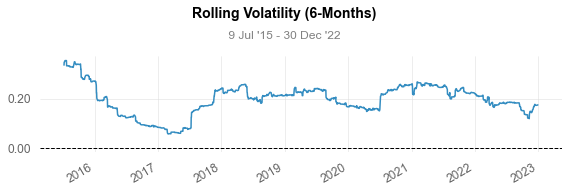

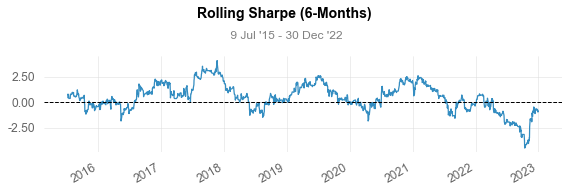

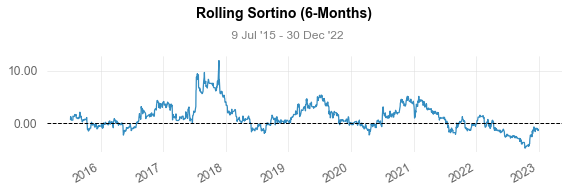

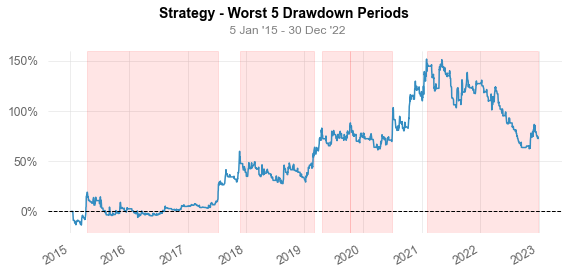

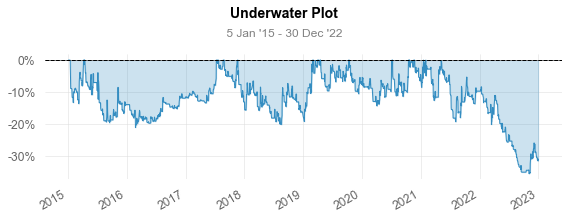

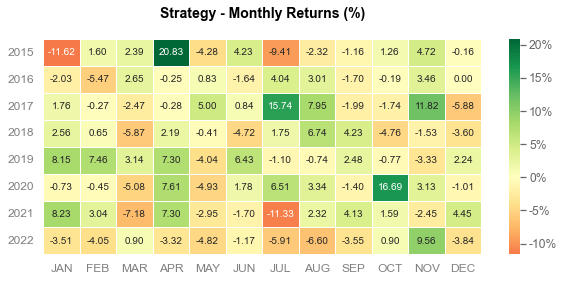

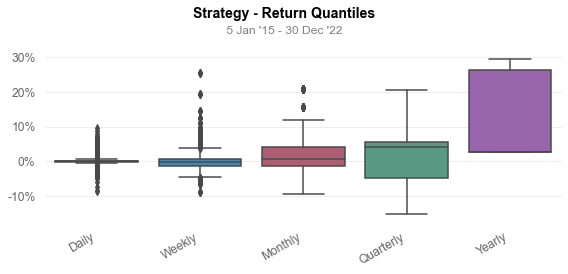

In [32]:
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)